# Import Libraries

In [263]:
import os
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import numpy as np
from tensorflow import keras
import pandas as pd

%load_ext autoreload
%autoreload 2

# Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import cv2 
import skimage
import lime
import lime.lime_image as li
from skimage.segmentation import mark_boundaries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# CNN Class and methods
from src.model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Declare global constants for defining CNN layers

In [170]:
'''
   CNN Layers for builing models
'''
CONV2D_3x3_32 = 'Conv2D3x3_32'
CONV2D_3x3_64 = 'Conv2D3x3_64'
CONV2D_3x3_128 = 'Conv2D3x3_128'
CONV2D_2x2_32 = 'Conv2D2x2_32'
CONV2D_2x2_64 = 'Conv2D2x2_64'
CONV2D_2x2_128 = 'Conv2D2x2_128'

BATCH_NORMAL = 'BatchNormal'
MAXPOOL_2D = 'MaxPool2D'
DROPOUT_10PERCENT = 'DropOut_10percent'
DROPOUT_20PERCENT = 'DropOut_20percent'
FLATTEN_LAYERS = 'Flatten_layers'
DENSE = 'Dense'
DENSE_512 = 'Dense512'

# Description of the Pneumonia Dataset
- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). 
- There are 5,216 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

# Load Dataset

In [171]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [172]:
train = get_training_data('../../data/chest_xray/train')
test = get_training_data('../../data/chest_xray/test')
val = get_training_data('../../data/chest_xray/val')

OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-171-5636fbc65197>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization and Preprocessing
- Create a Bar chart to show classification of images in Train, Test, and Validation data

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

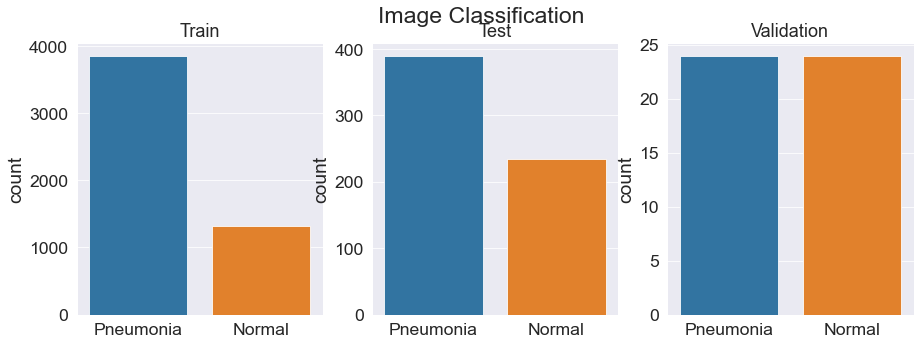

In [173]:
lst_train = lst_test = lst_val = []
for i in train:
    if(i[1] == 0):
        lst_train.append("Pneumonia")
    else:
        lst_train.append("Normal")
        
lst_test = []
for i in test:
    if(i[1] == 0):
        lst_test.append("Pneumonia")
    else:
        lst_test.append("Normal")       
        
lst_val = []
for i in val:
    if(i[1] == 0):
        lst_val.append("Pneumonia")
    else:
        lst_val.append("Normal") 

fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Image Classification\n")
sns.set_style('darkgrid')
sns.set_context("paper", font_scale=2.0)

ss0 = sns.countplot(lst_train, ax=ax[0])  
ax[0].set_title("Train",fontsize=18)

ss1= sns.countplot(lst_test, ax=ax[1])  
ax[1].set_title("Test",fontsize=18)

ss2 = sns.countplot(lst_val, ax=ax[2])  
ax[2].set_title("Validation",fontsize=18)

plt.savefig('../../visualization/image_classification.png', dpi=300)

## Let's visualize couple of images

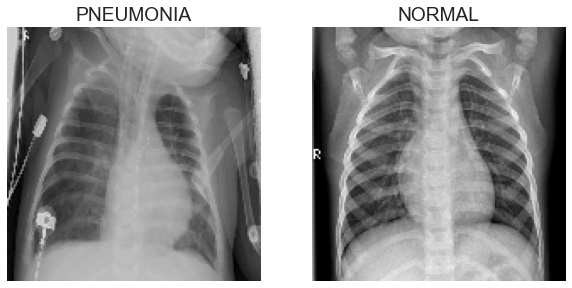

In [174]:
figure = plt.figure(figsize=(10,10))
figure.add_subplot(1, 2, 1)

plt.imshow(train[0][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[0][1]])

figure.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[-1][1]])
plt.savefig('../../visualization/sample_Xrays.png', dpi=300)
plt.show()

## Merge separate x_train,y_train and X_test,y_test and x_val,y_val into three datasets
- X_train is train dataset
- X_test is test dataset
- y_test is validation dataset

In [175]:
'''
    Merge train and test datasets combining both NORMAL and PNEUMONIA X-Rays
'''
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

## Perform Greyscale Normalization

In [176]:
'''
    Perform grayscale normalization
'''
# Normalize data
X_train = np.array(X_train, dtype=int) / 255
X_val = np.array(X_val, dtype=int) / 255
X_test = np.array(X_test, dtype=int) / 255

## Resize data to prepare for running CNN models

In [177]:
'''
    Resize data for deep learning
''' 
X_train = X_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

# Run FSM
- 1) Call cnn_model utility to intantiate the model.
   cnn_model also sets the default parameters and hyperparameters for construcing CNN layers
- 2) Build model.
   Build_model takes twoa list of steps as input.
   Model is built in the order of the steps defined as constants strings.

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
flatten_50 (Flatten)         (None, 720000)            0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 720001    
Total params: 720,897
Trainable params: 720,897
Non-trainable params: 0
_________________________________________________________________
{'loss': [1.403540015220642, 0.41859719157218933, 0.39727821946144104, 0.38807743787765503, 0.31811633706092834, 0.3296710252761841, 0.3072721064090729, 0.24484579265117645, 0.23947778344154358, 0.2280699908733368, 0.21982342004776, 0.21795569360256195, 0.20089052617549896, 0.20800834894180298, 0.20271313190460205], 'accuracy': [0.732934832572937, 0.8177786469459534, 0.83648

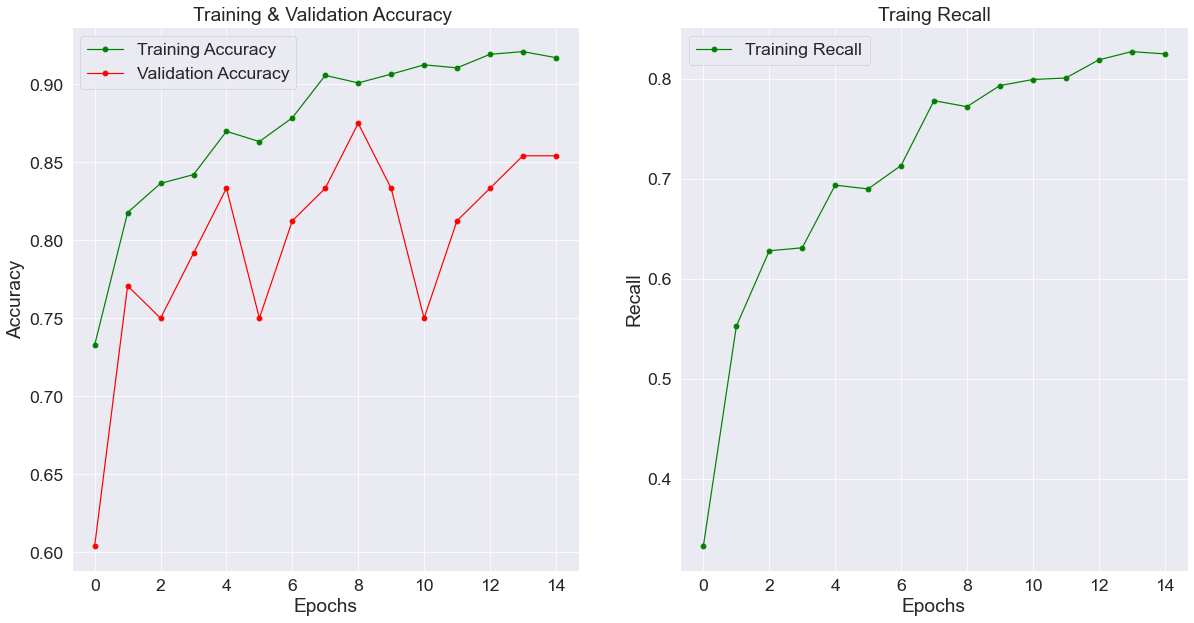

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.83      0.97      0.90       390
   Normal (Class 1)       0.93      0.67      0.78       234

           accuracy                           0.86       624
          macro avg       0.88      0.82      0.84       624
       weighted avg       0.87      0.86      0.85       624

[[379  11]
 [ 77 157]]
Sample of Penumonia X-rays
sample Normal X_rays


../../src/model_utils.py:379: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = f.add_subplot(gs[0, 1])


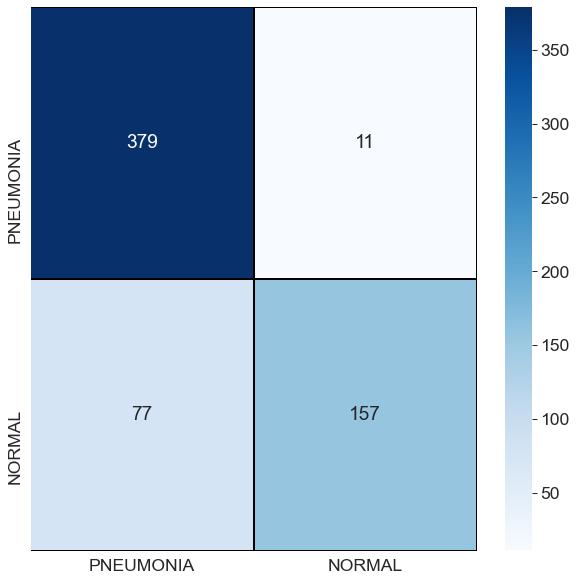

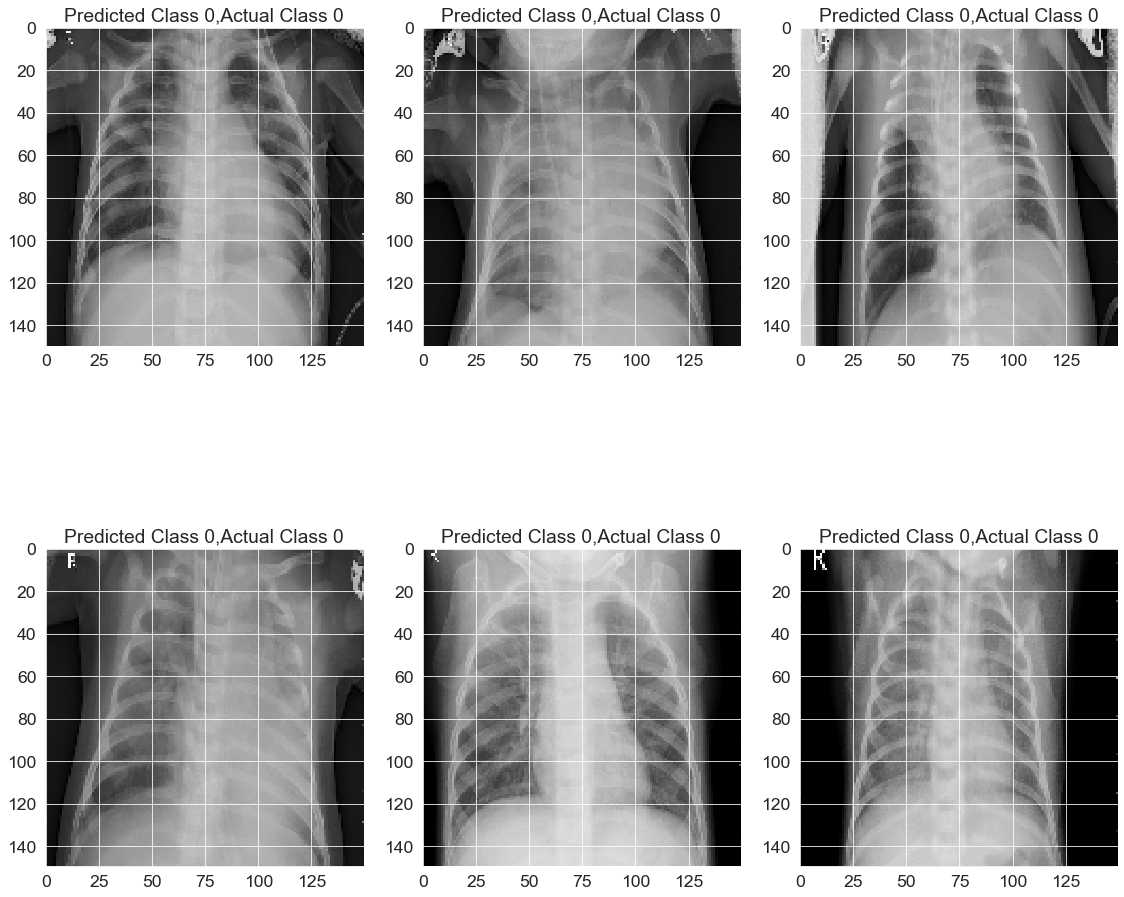

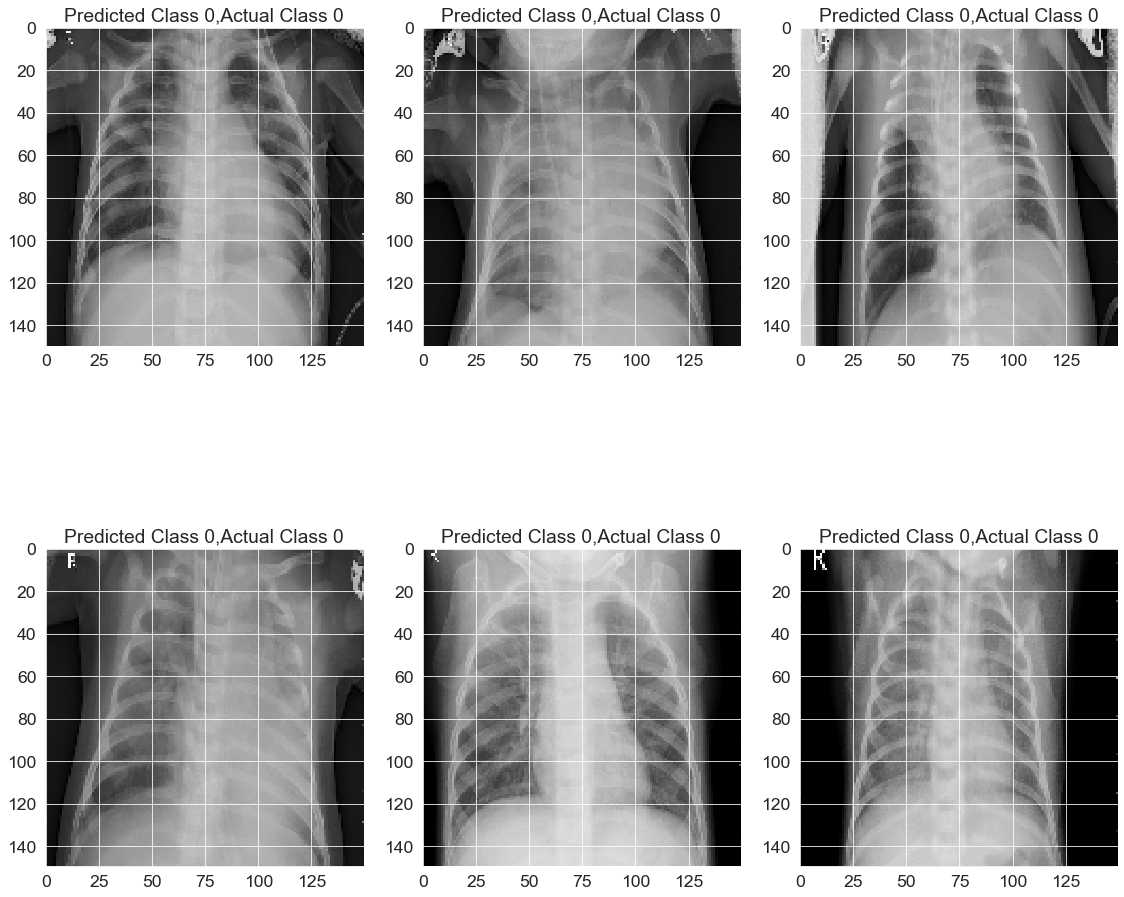

In [203]:
'''
    First Simple Model
    CNN Layers: Conv2D, 32 units, 3x3 filter | Flatten Layers | Dense Output Layer
    Epochs: 15
'''
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, FLATTEN_LAYERS])
history = cnn.fit_report_model("FSM_", 32, 15)

# Run more complex model to improve on accuracy
    Function: fit_and_report 
    1) Build models by sequencing various layer methods.
    2) Final layer is set 1 and with Sigmoid.
    3) Print Confustion Matrix
    4) Sample X-Rays from Pneumonia and Normal pool

# Model 1: Model 1 with Epoch=12; Batch_Size =32

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_94 (Dense)             (None, 128)               11829376  
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)             

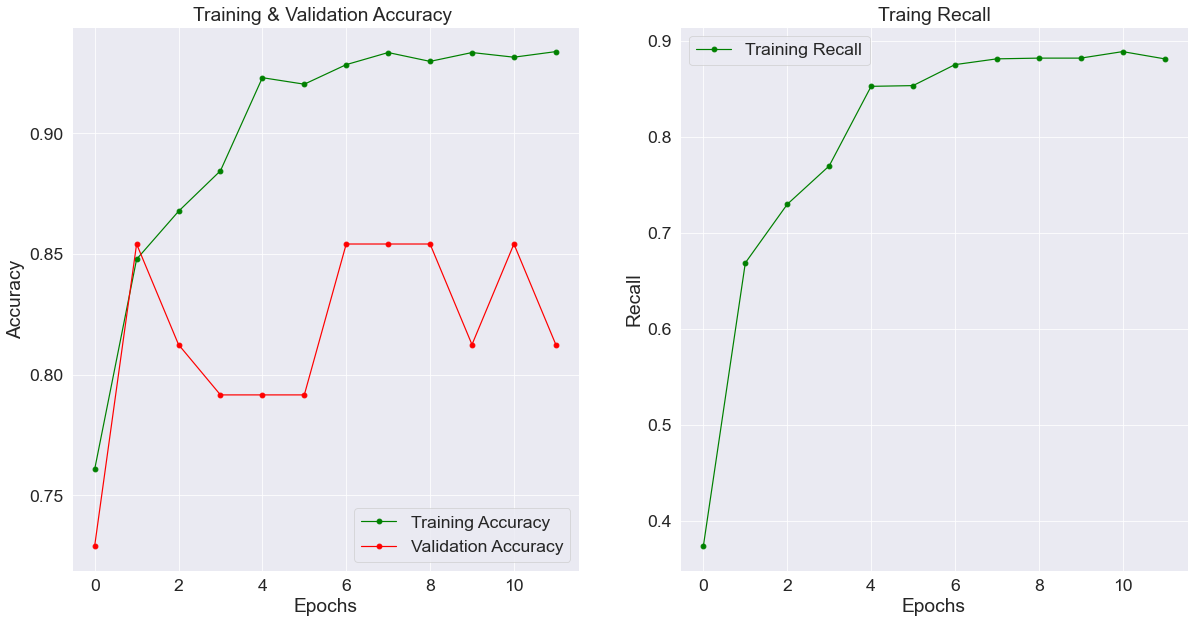

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.97      0.93       390
   Normal (Class 1)       0.94      0.80      0.87       234

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624

[[379  11]
 [ 46 188]]
Sample of Penumonia X-rays
sample Normal X_rays


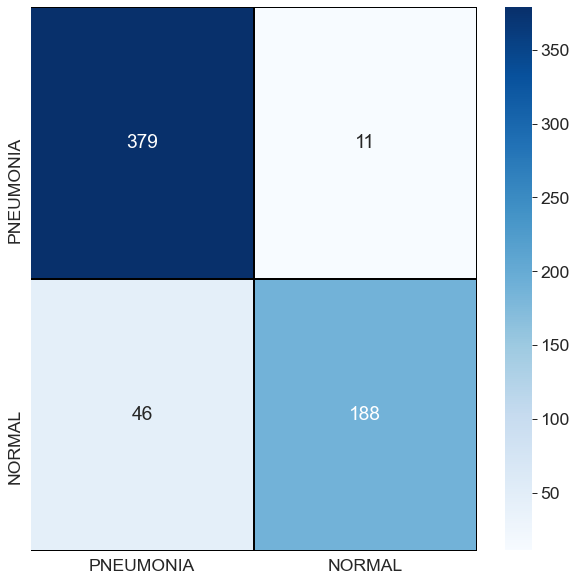

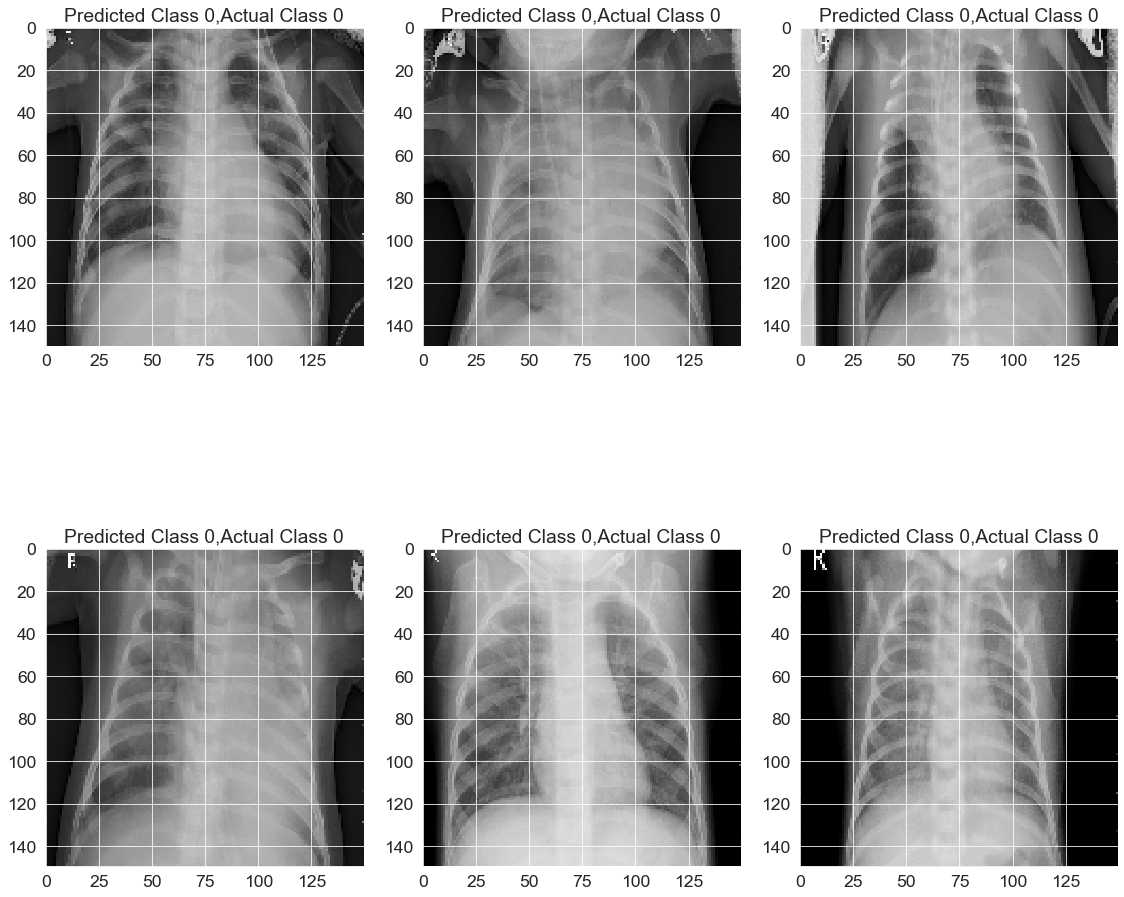

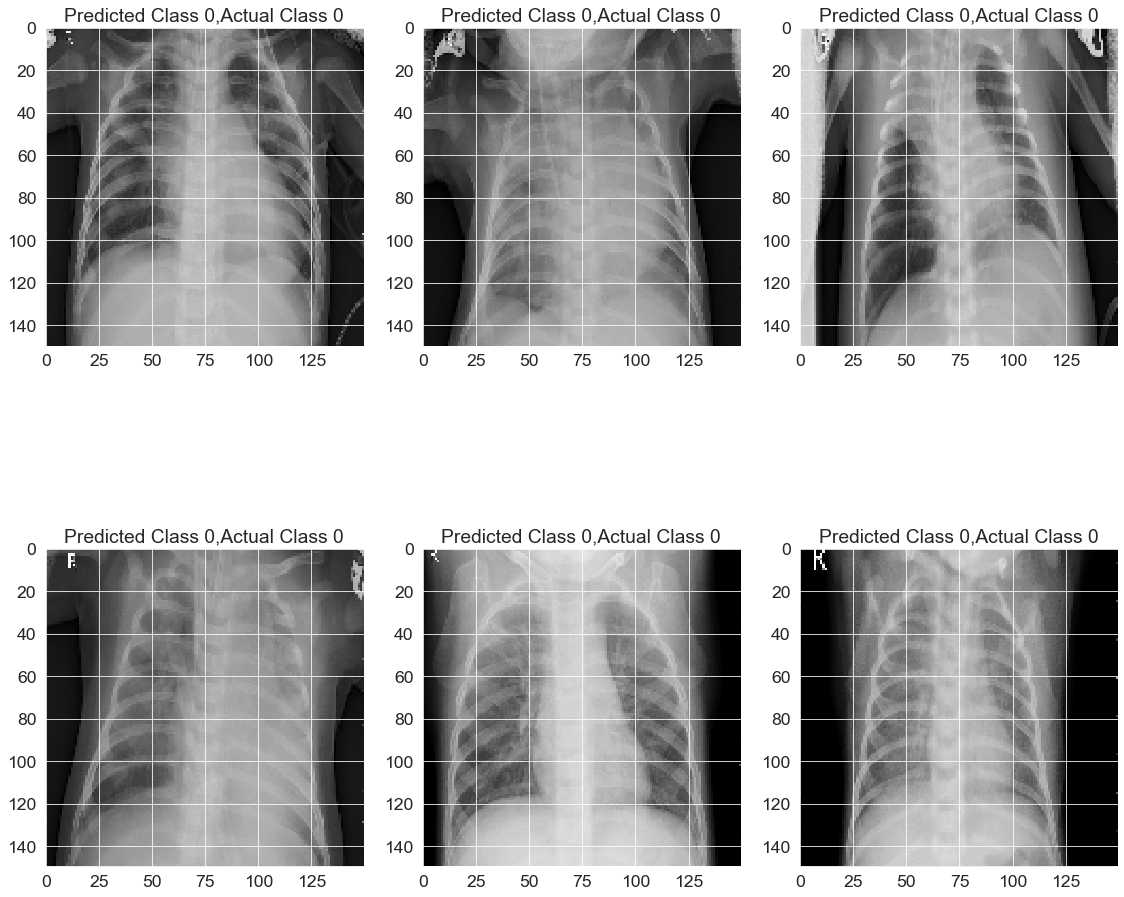

In [218]:
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model1_Epoch12_Batch32 ", 32, 12)

# Model 2:  50 Epochs - Batch 32

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_96 (Dense)             (None, 128)               11829376  
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)             

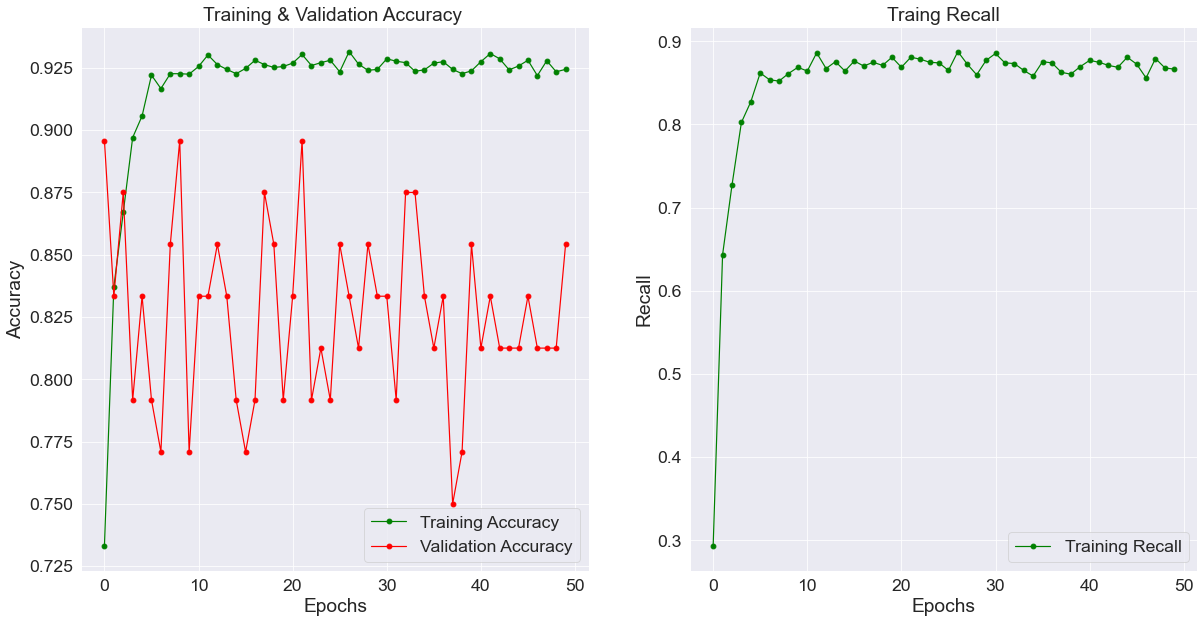

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.95      0.93       390
   Normal (Class 1)       0.91      0.82      0.87       234

           accuracy                           0.90       624
          macro avg       0.91      0.89      0.90       624
       weighted avg       0.90      0.90      0.90       624

[[371  19]
 [ 41 193]]
Sample of Penumonia X-rays
sample Normal X_rays


../../src/model_utils.py:379: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = f.add_subplot(gs[0, 1])


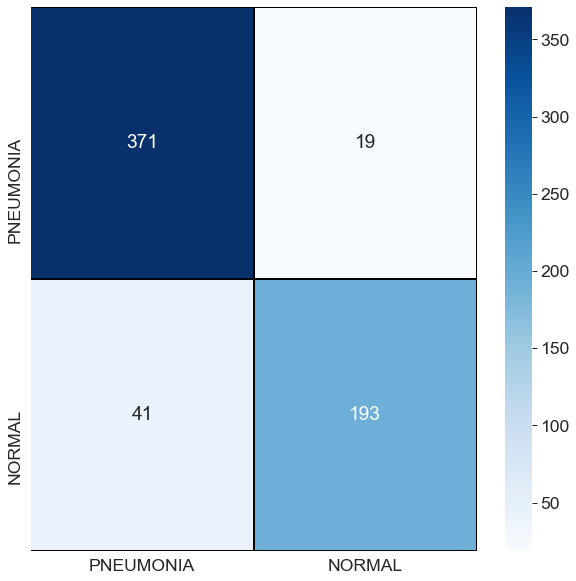

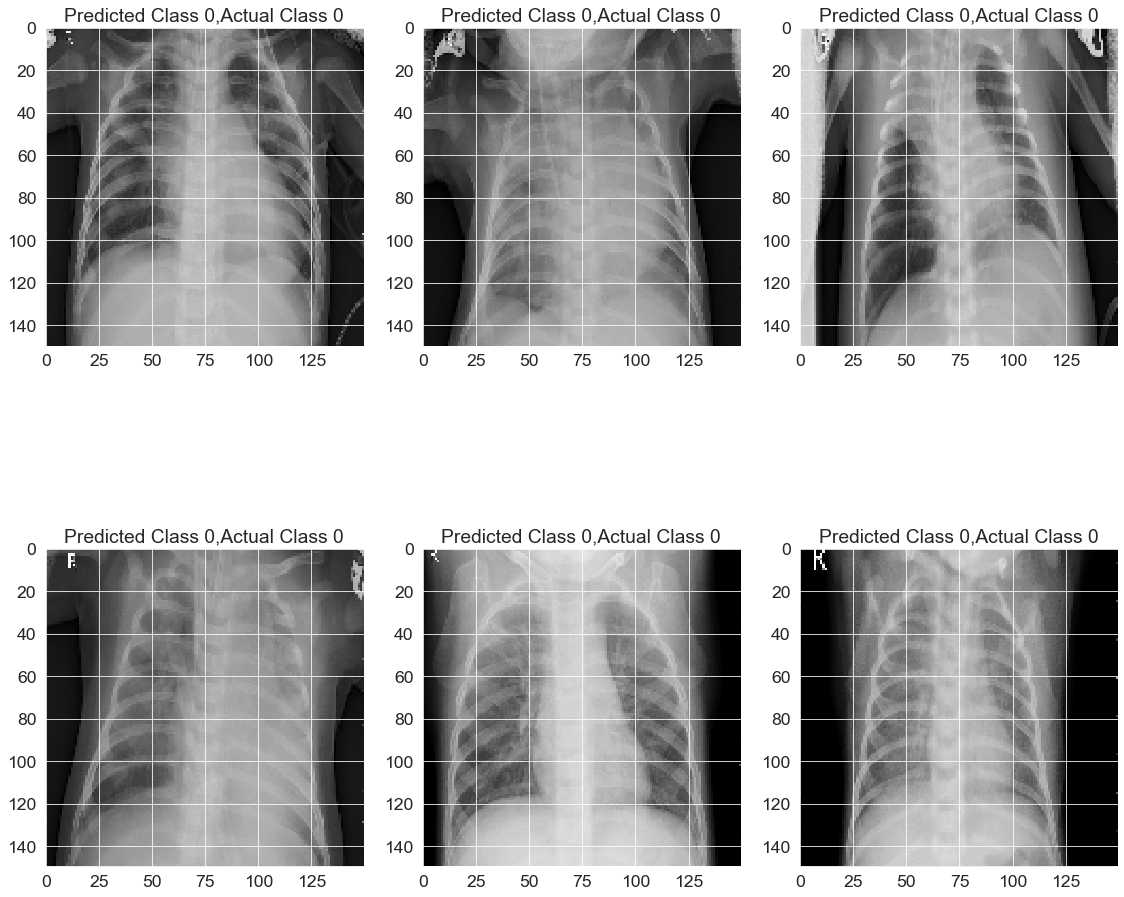

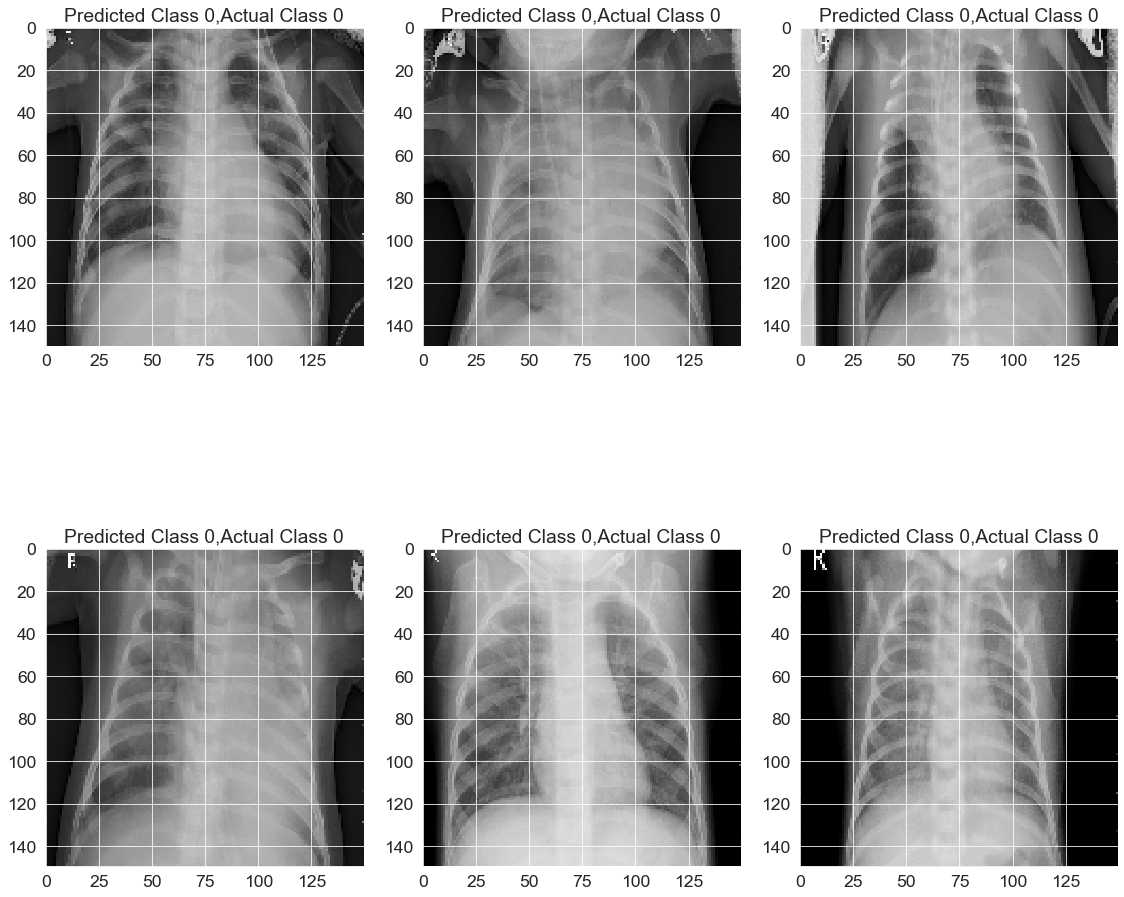

In [224]:
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model2_Epoch50_Batch32__", 32, 50)

# Model 3: With 20 Epochs Batch_size 32

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 128)               11829376  
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)             

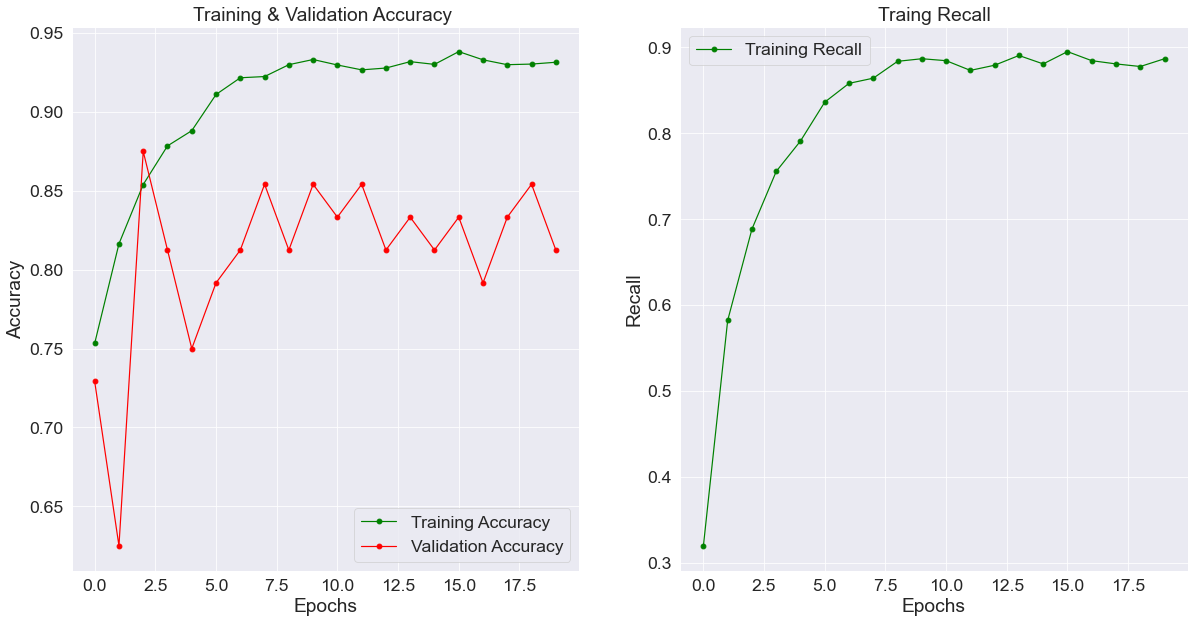

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.97      0.92       390
   Normal (Class 1)       0.94      0.78      0.85       234

           accuracy                           0.90       624
          macro avg       0.91      0.87      0.89       624
       weighted avg       0.90      0.90      0.90       624

[[378  12]
 [ 52 182]]
Sample of Penumonia X-rays
sample Normal X_rays


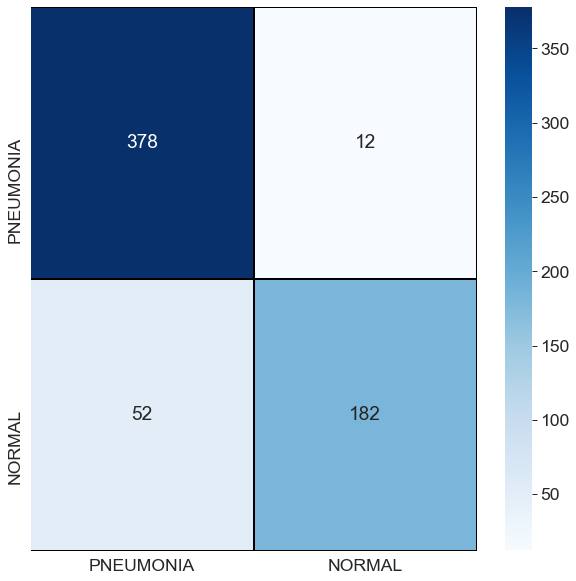

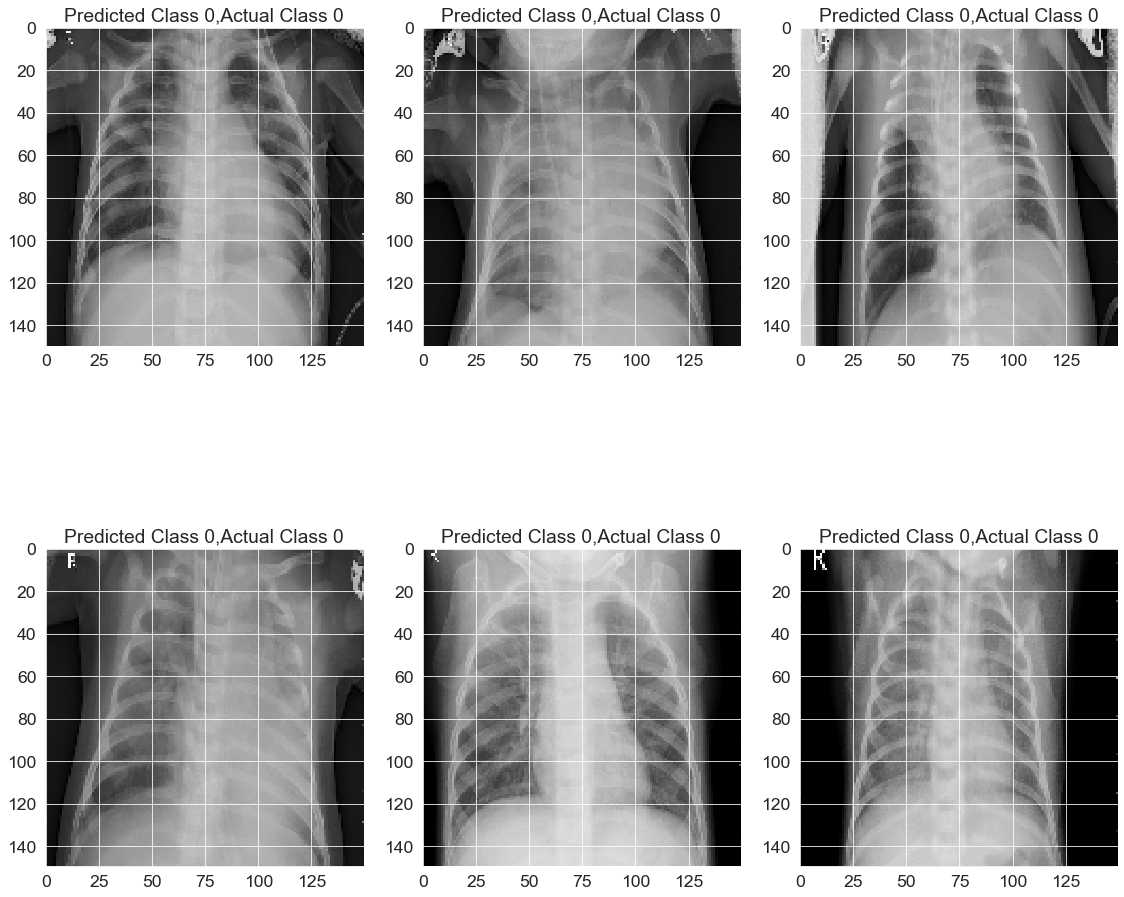

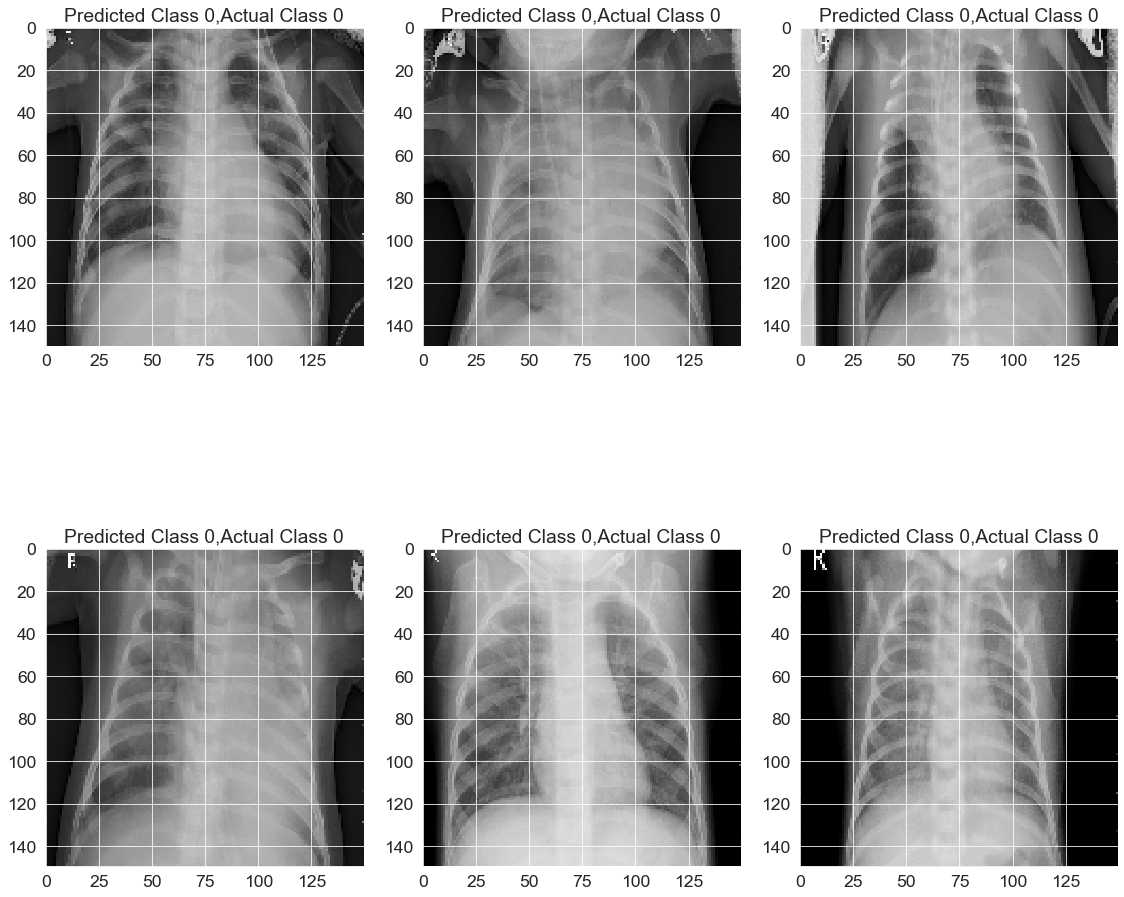

In [226]:
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model3_Epoch20_", 32, 20)

# Model 4: 15 Epochs Batch_Size 32

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_102 (Dense)            (None, 128)               11829376  
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)             

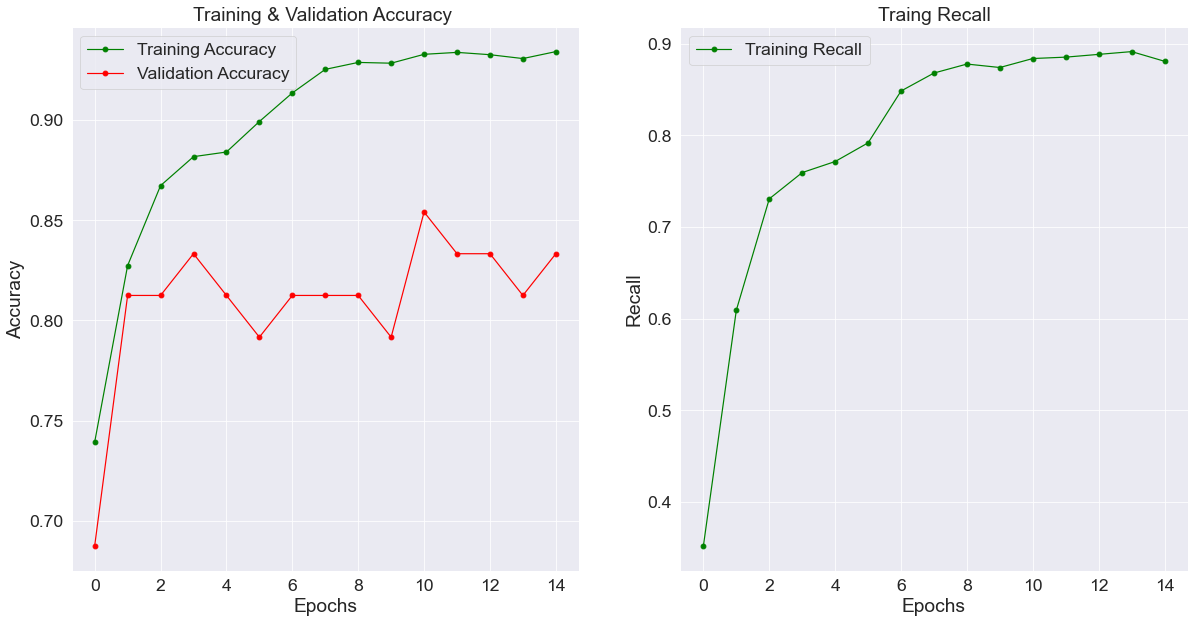

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.97      0.93       390
   Normal (Class 1)       0.94      0.80      0.86       234

           accuracy                           0.91       624
          macro avg       0.91      0.88      0.90       624
       weighted avg       0.91      0.91      0.90       624

[[378  12]
 [ 47 187]]
Sample of Penumonia X-rays
sample Normal X_rays


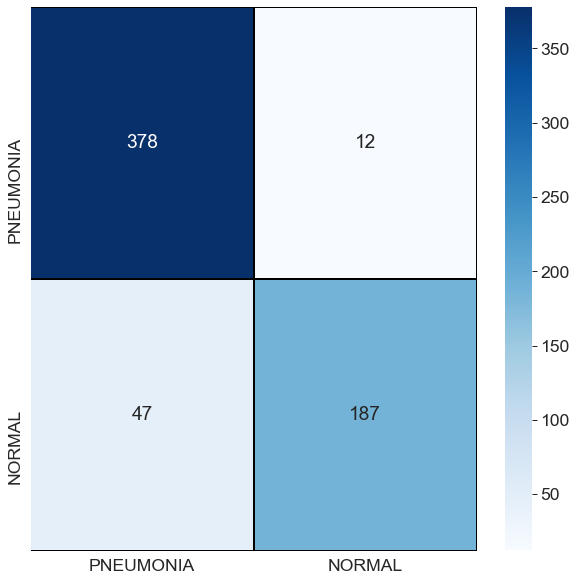

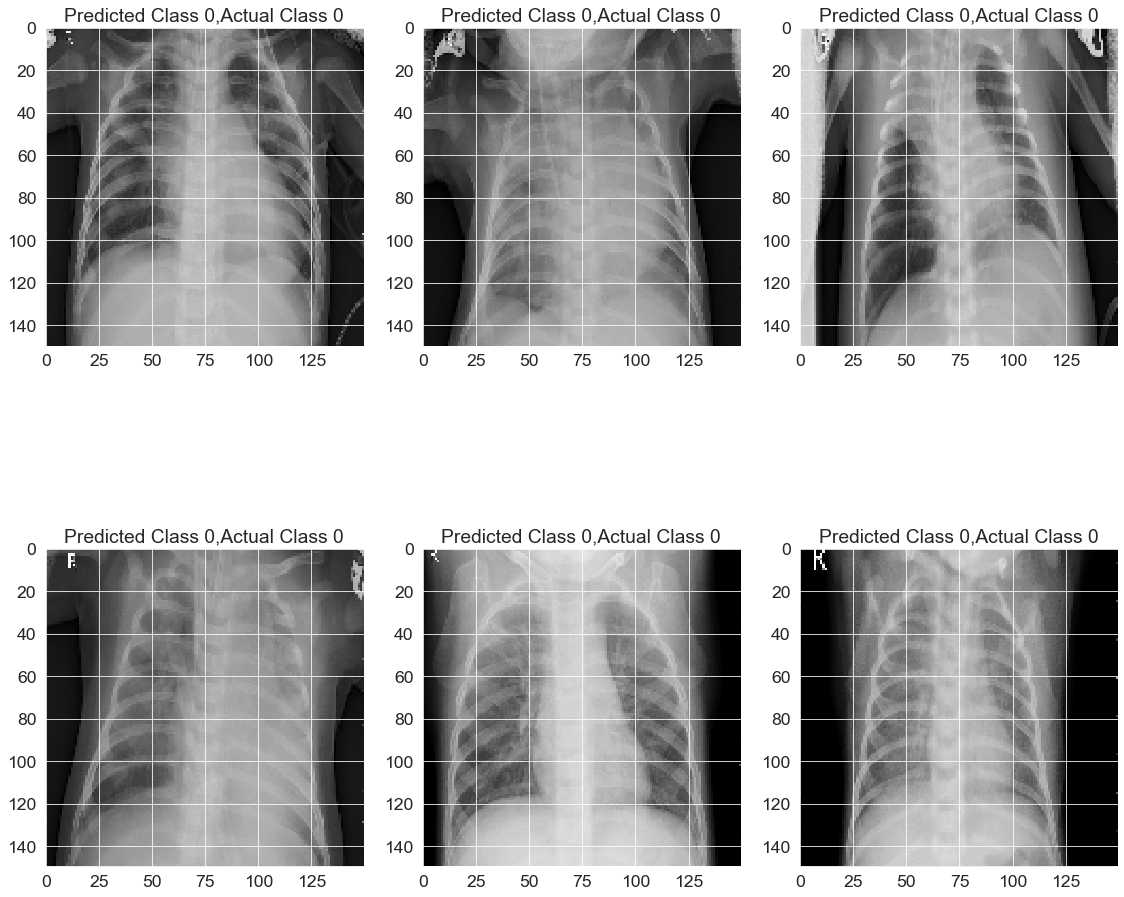

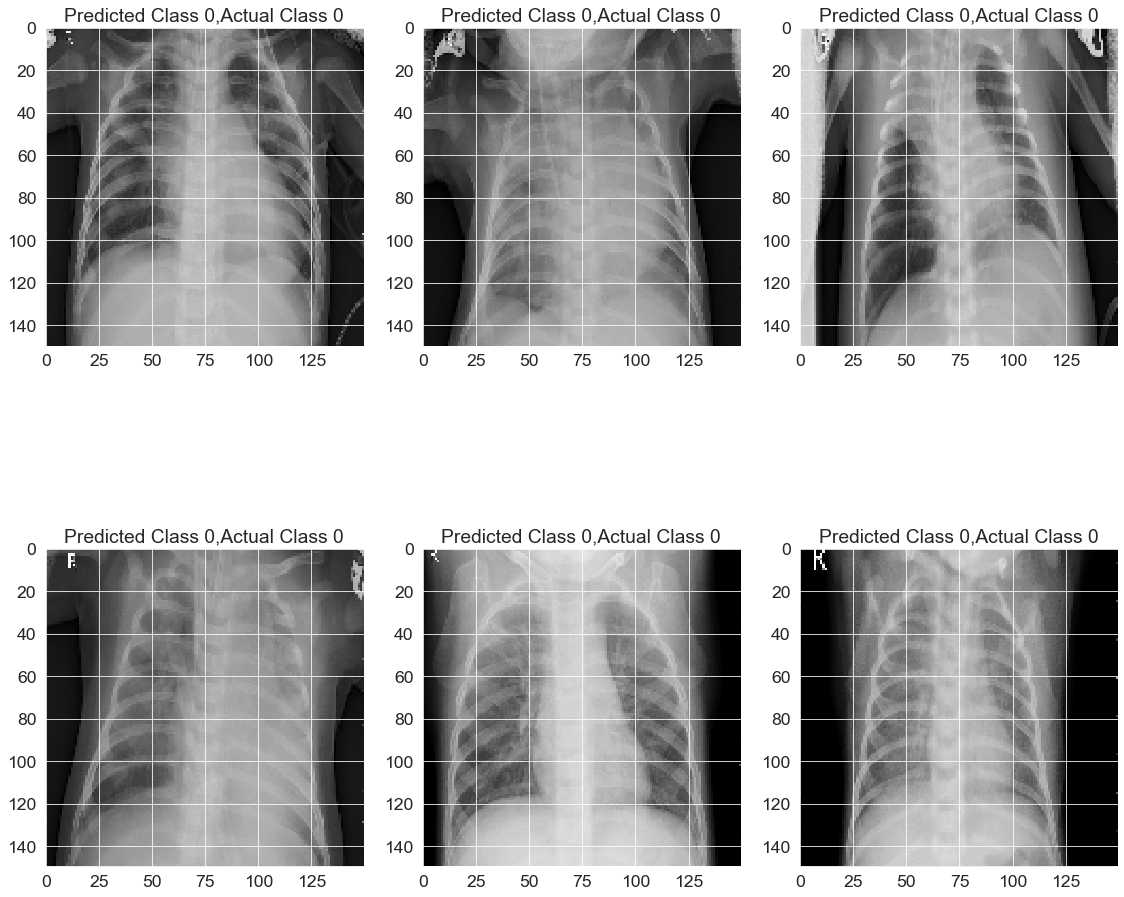

In [227]:
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model4_Epoch15_Batch_32 ", 32, 15)

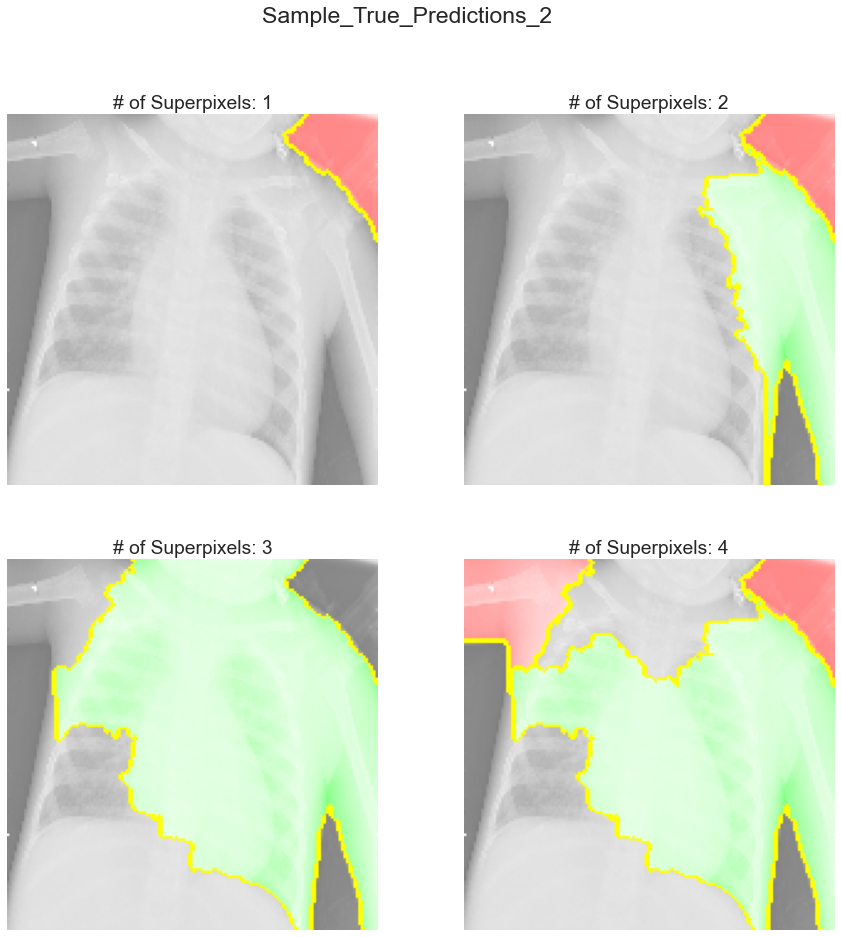

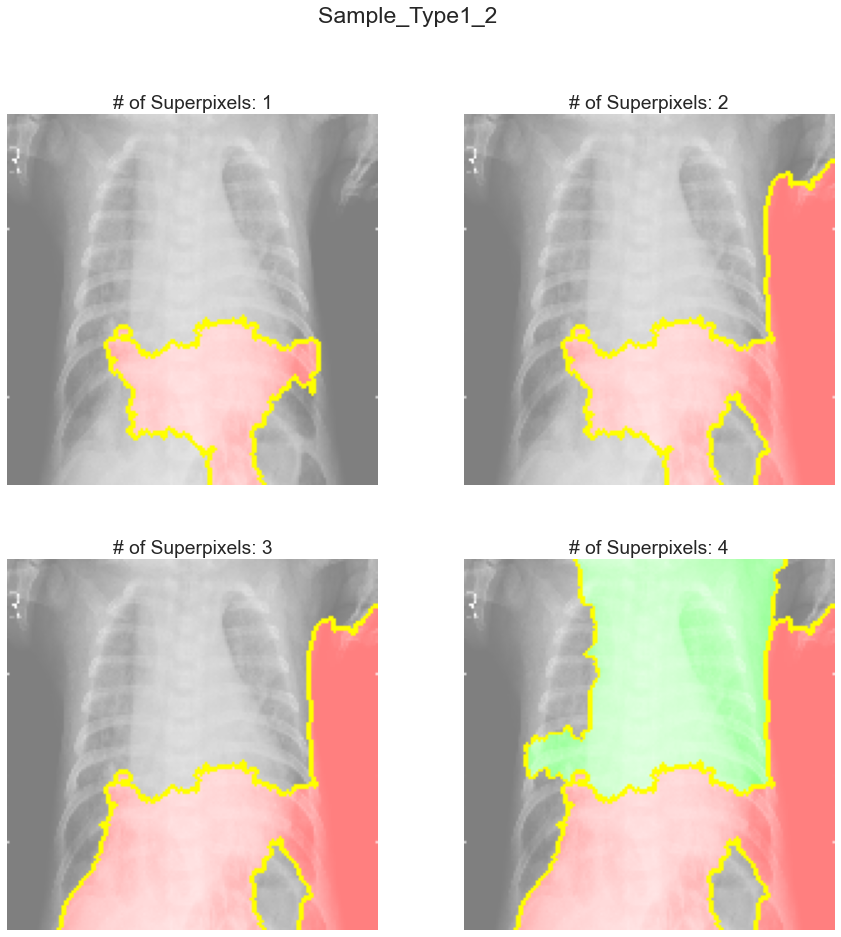

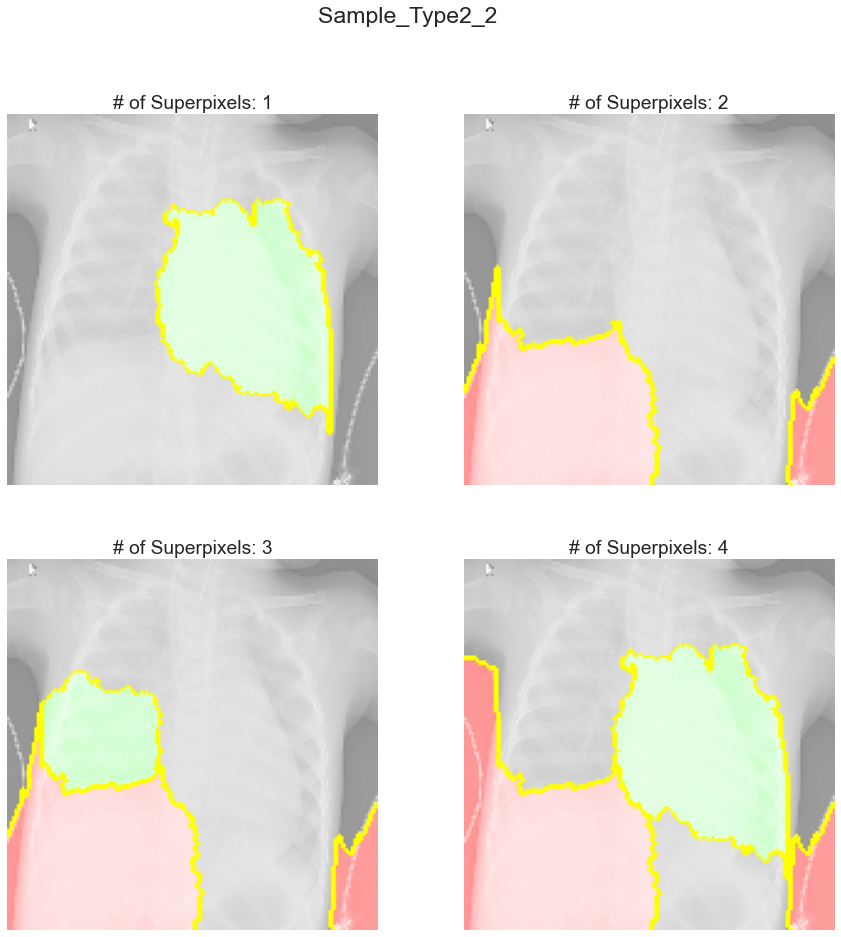

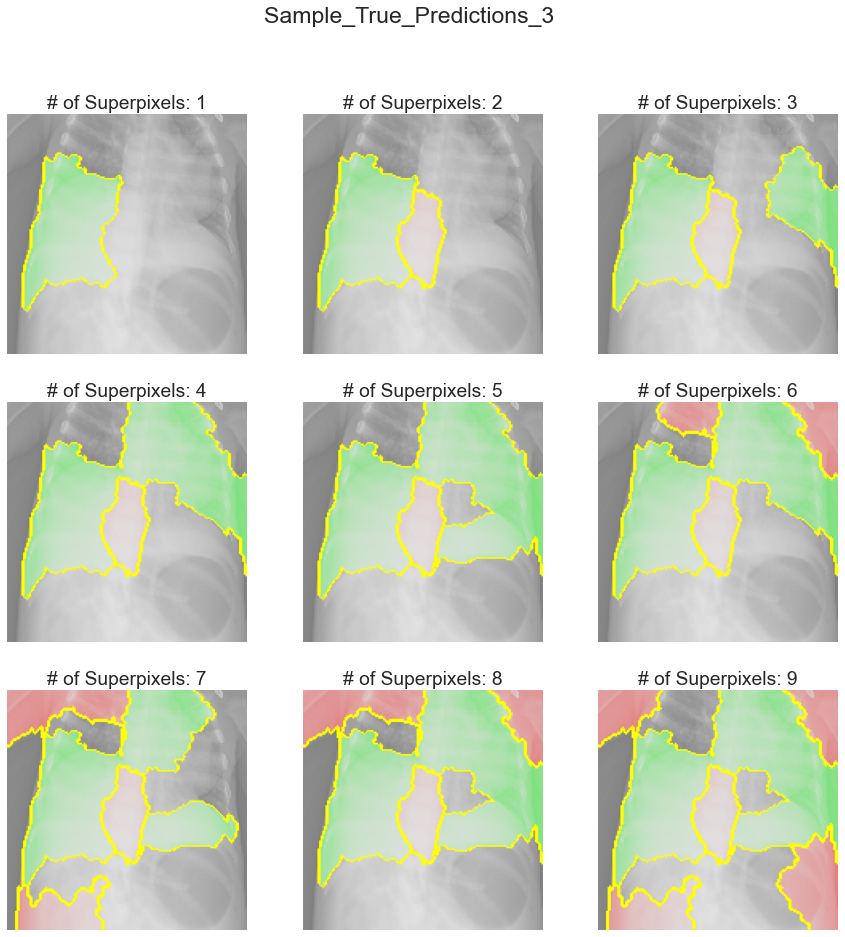

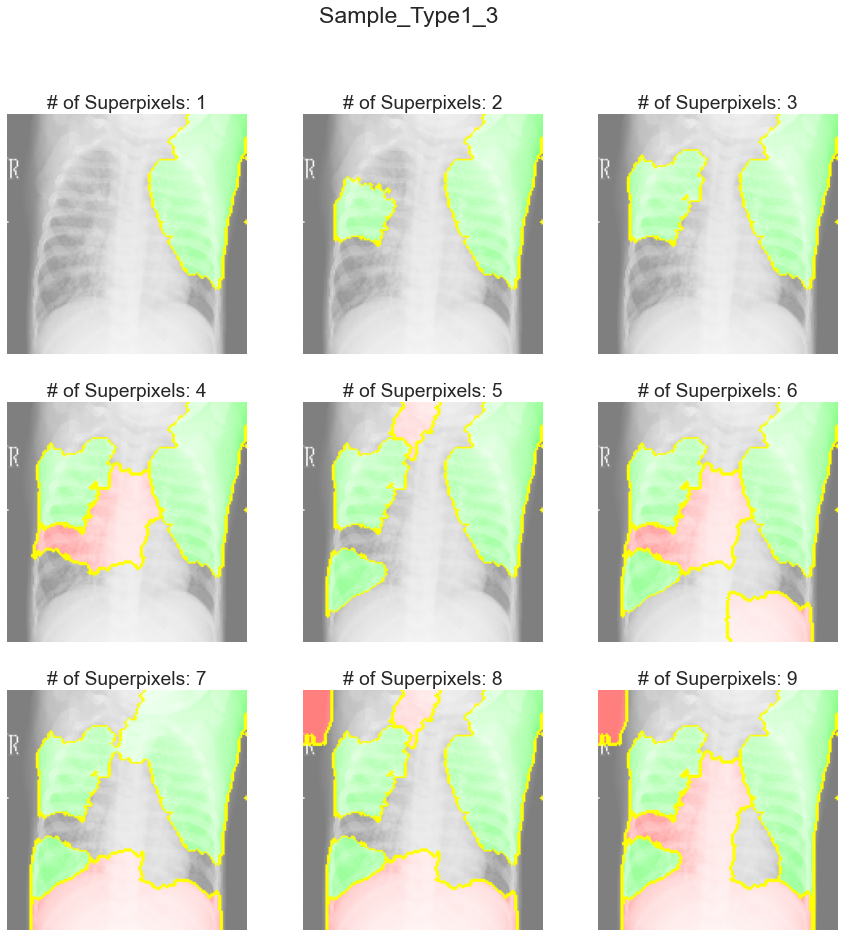

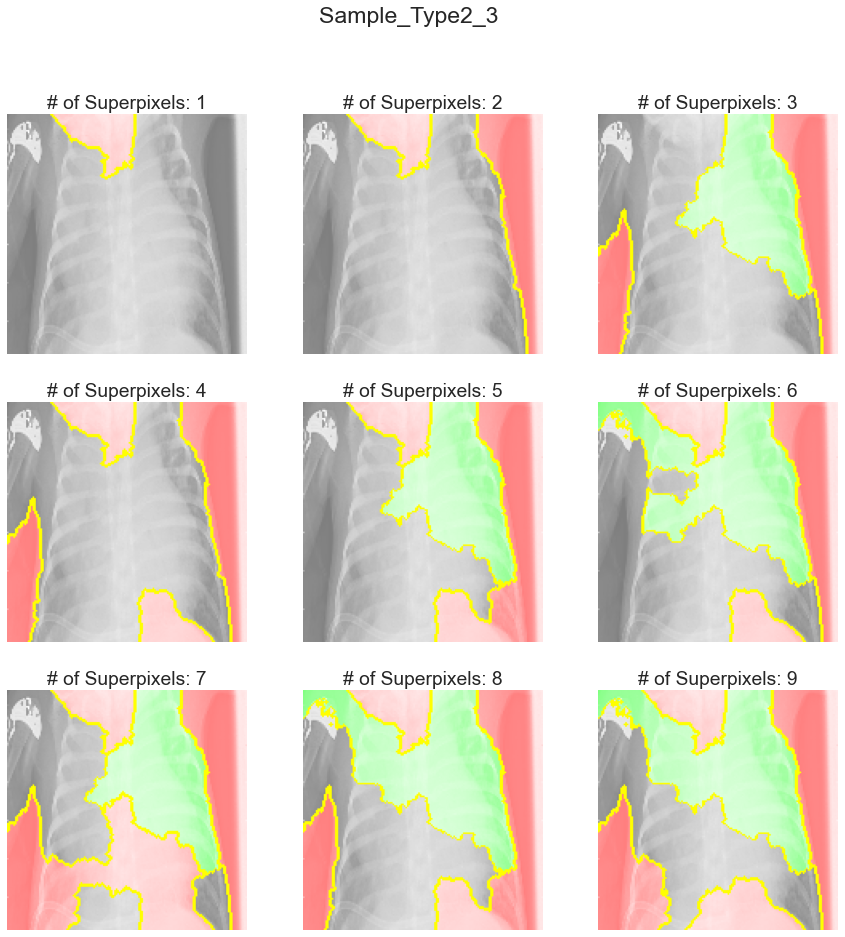

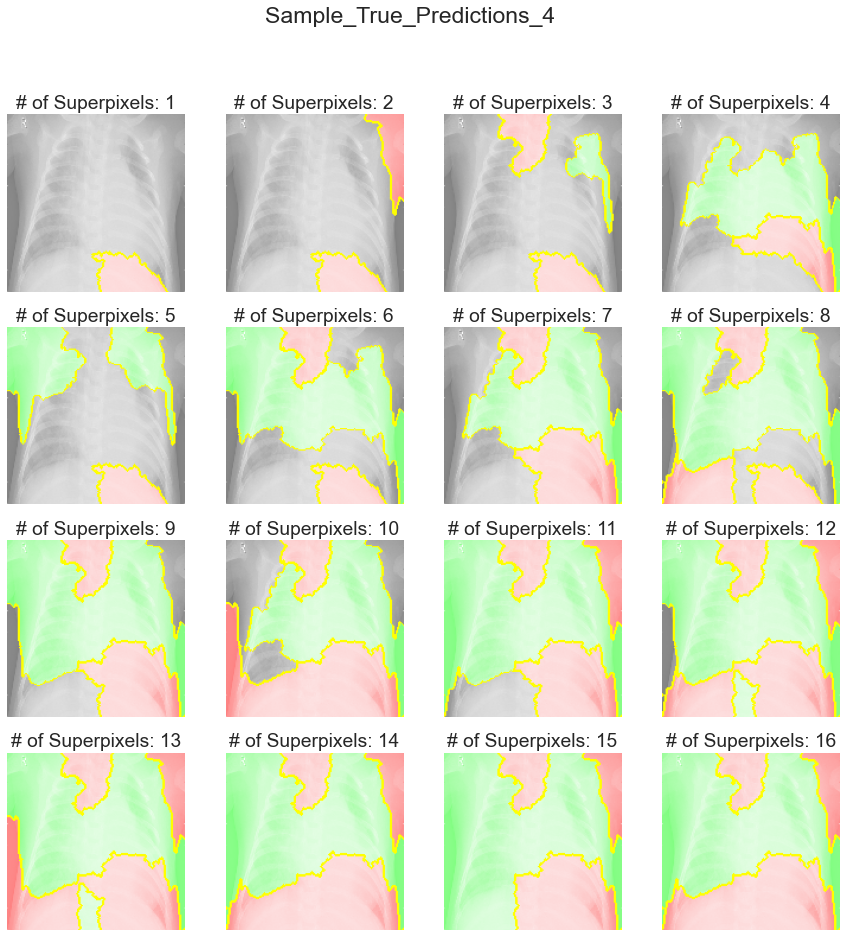

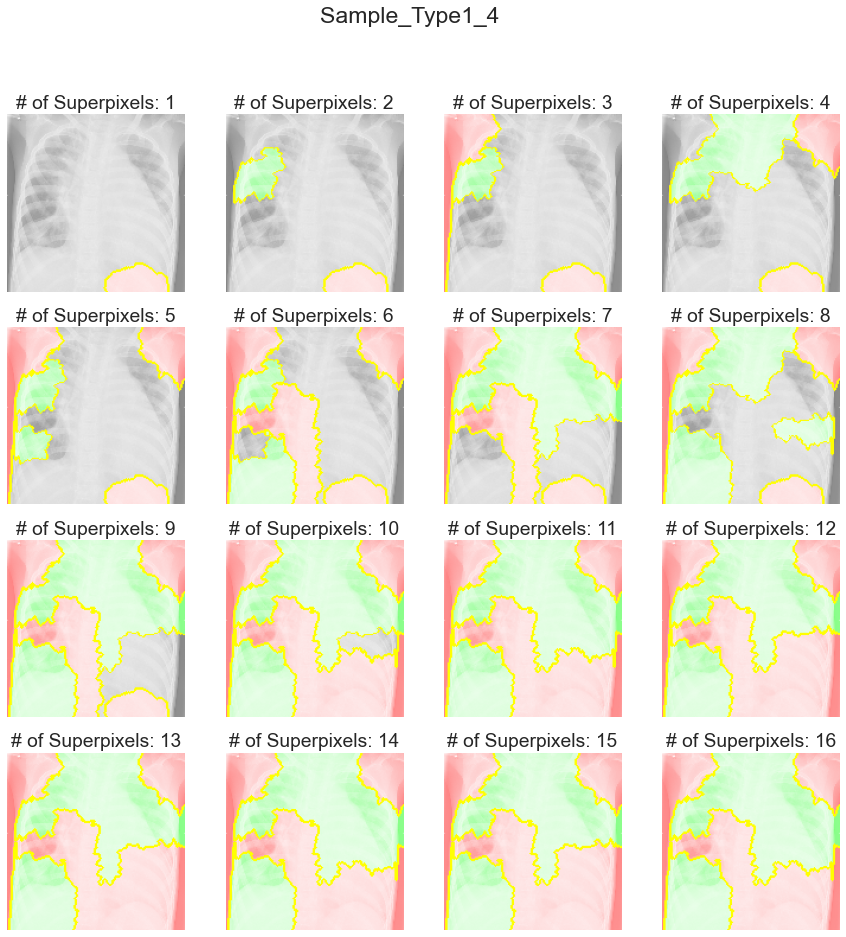

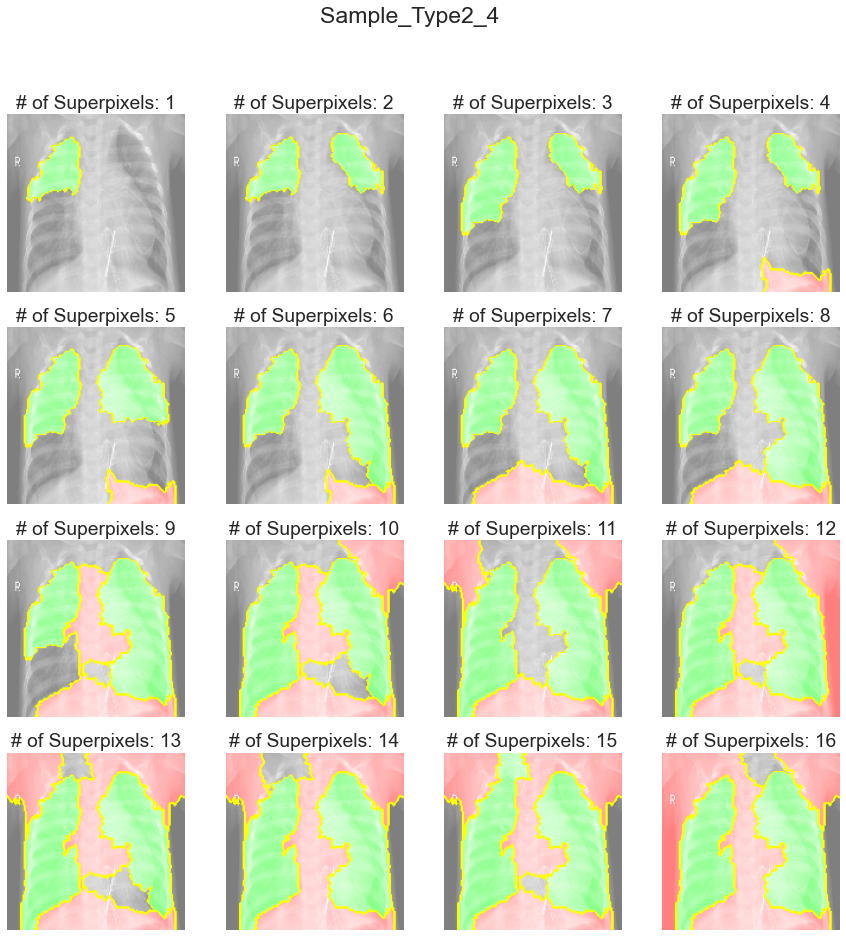

In [272]:
'''
    Prints a set of LIME Imags from 3 lists: True Predictions, Type_1 Error, and Type_2 Error
    Call the method cnn.print_truePred_type1_type2(dimension_of_images)  # 2 means 2x2 frame.
'''
cnn.print_truePred_type1_type2_images(2)
cnn.print_truePred_type1_type2_images(3)
cnn.print_truePred_type1_type2_images(4)

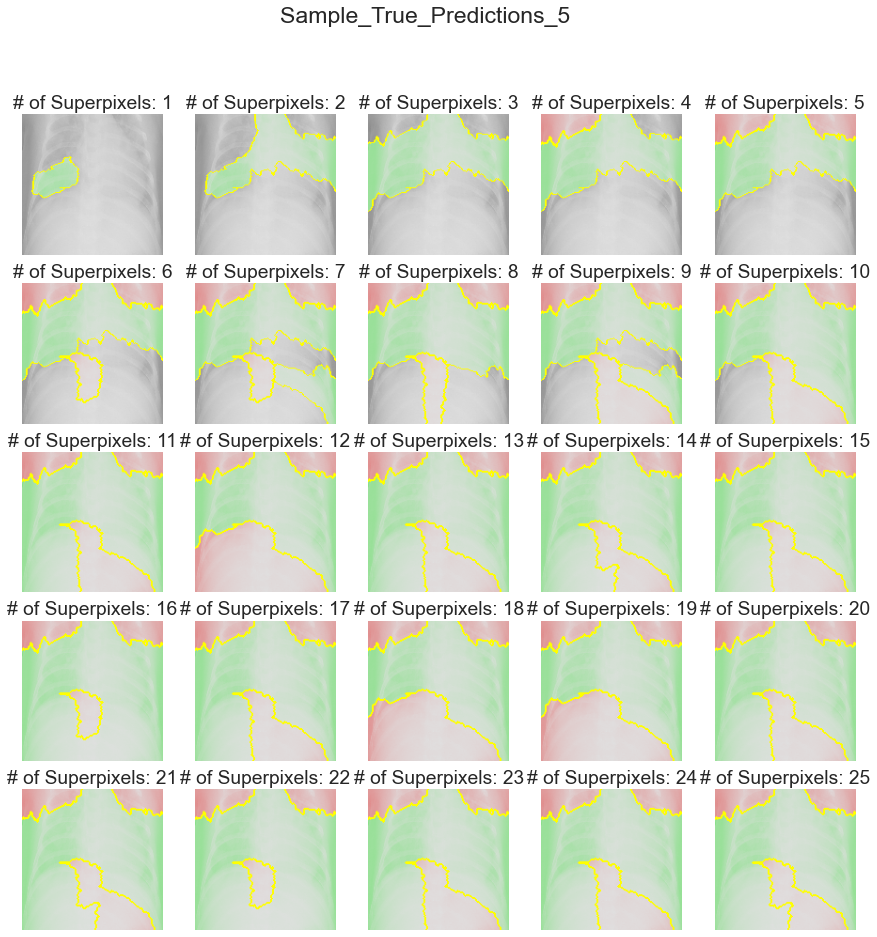

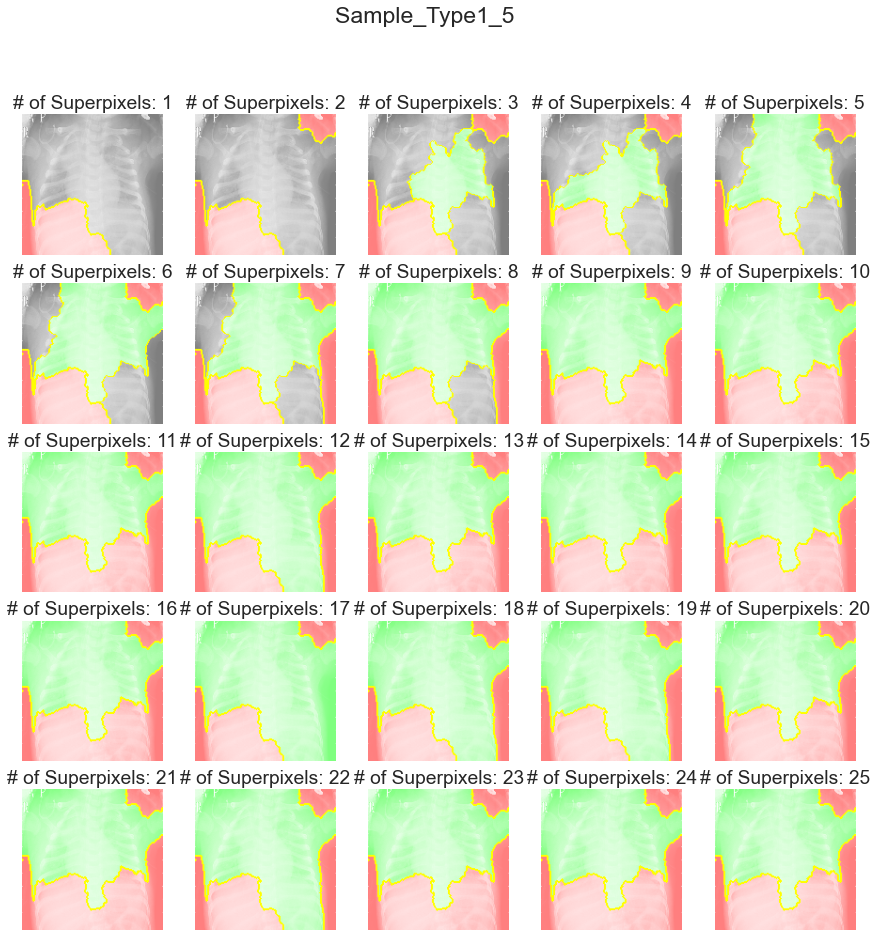

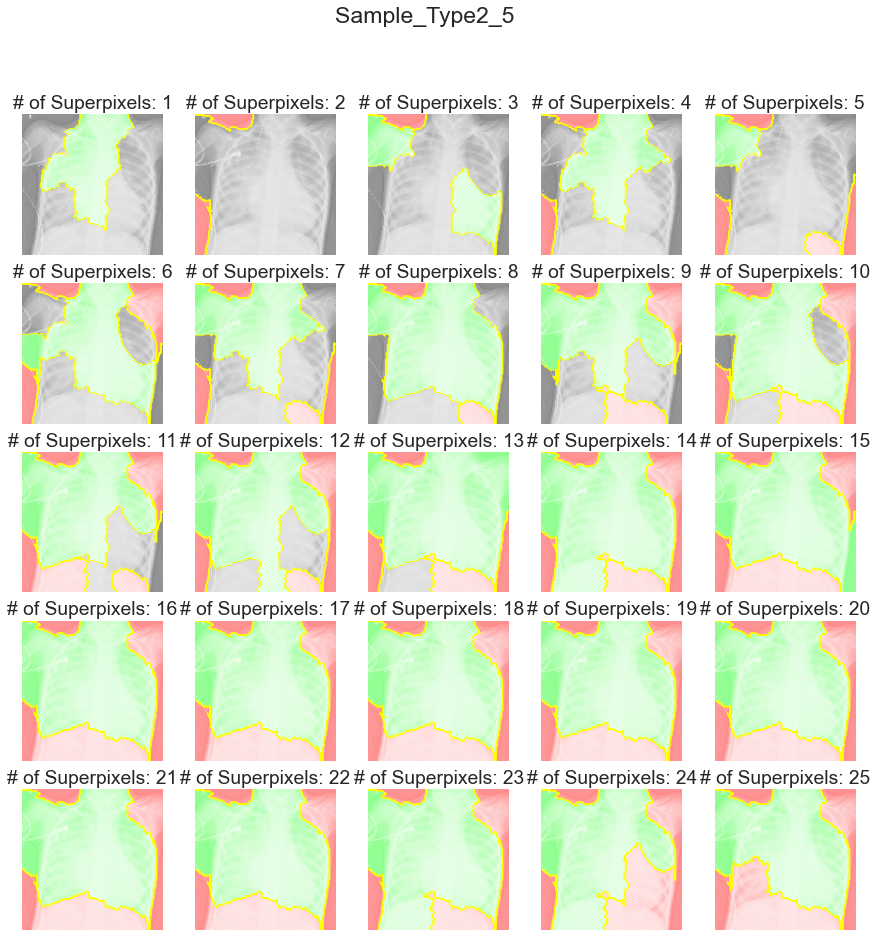

In [274]:
cnn.print_truePred_type1_type2_images(5)